# Lockman-SWIRE check HELP IDs

Because the photo-zs were computed from an early version of the masterlist, there is some concern that the HELP IDs may have changed. In this notebook we will check for differences and convert the old IDs to the new ones if required.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import join, Column, Table
import numpy as np
from pymoc import MOC

from collections import Counter

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

In [3]:

OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

OLD_SUFFIX = "20170710"
NEW_SUFFIX = "20180219"

ML_FOLDER = "../../dmu1/dmu1_ml_Lockman-SWIRE/"

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
photoz = Table.read("./data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised.fits")
master_catalogue = Table.read("{}data/master_catalogue_lockman-swire_{}.fits".format(ML_FOLDER, NEW_SUFFIX))["help_id","ra","dec"]


In [5]:
photoz.meta = None

#photoz = photoz['help_id', 'z1_median', 'RA', 'DEC']

photoz['RA'].name = 'photoz_ra'
photoz['DEC'].name = 'photoz_dec'
#photoz['z1_median'].name = 'redshift'

photoz['z1_median'][photoz['z1_median'] < 0] = np.nan  # -99 used for missing values

In [6]:
merged_table = join(master_catalogue, photoz, join_type='left')

# Fill values
merged_table['z1_median'].fill_value = np.nan
merged_table = merged_table.filled()

In [7]:
print("Master catalogue length: {}".format(len(master_catalogue)))
print("Photoz length: {}".format(len(photoz)))
print("Merged length: {}".format(len(merged_table)))
print("Merged photozs length: {}".format(np.sum(~np.isnan(merged_table['z1_median']))))
print("Nonnan photozs length: {}".format(np.sum(~np.isnan(photoz['z1_median']))))

Master catalogue length: 4366298
Photoz length: 1382785
Merged length: 4366298
Merged photozs length: 797328
Nonnan photozs length: 1377480


### Check positions

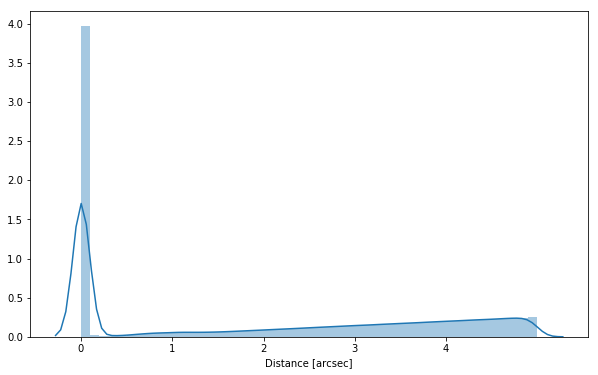

In [8]:
photoz['photoz_ra'].unit = u.deg
photoz['photoz_dec'].unit = u.deg
nb_merge_dist_plot(
    SkyCoord(photoz['photoz_ra'], photoz['photoz_dec']),
    SkyCoord(master_catalogue['ra'], master_catalogue['dec'])
)

In [9]:
def helpid_merge(catalogue, RA_COL, DEC_COL, master_catalogue, radius=0.4*u.arcsec):
    """Add a column with new HELP_ids to some catalogue.

    This function cross-match a catalogue with the HELP latest masterlist:
    
    Occasionally some catalogue was produced from an out of date masterlist
    leading to subtle differences in help_ids and causing problems with
    joins and all means depending on help_ids for matches.
    
    This code uses a positional cross match to add up to date help_id data.
   
    Parameters
    ----------
    catalogue: astropy.table.Table
        The table containing the catalogue. It must not contain a 'help_id' 
        column. 
    RA_COL: 
        The name of the ra column in the catalogue
    DEC_COL:
        The name of the dec column in the catalogue
    master_catalogue: astropy.table.Table
        The table containing the updated masterlist IDs from the latest HELP 
        masterlist.
    radius: astropy.units.quantity.Quantity
        The radius to look for counterparts.  When more than one counterpart is
        found, the corresponding sources will be flagged.

    Return
    ------
    astropy.table.Table
        The catalogue with current help_id column added.

    """
    catalogue = catalogue.copy()
    cat_coords = SkyCoord(catalogue[RA_COL].data * u.deg,
                          catalogue[DEC_COL].data * u.deg)
    master_coords = SkyCoord(master_catalogue['ra'].data * u.deg,
                            master_catalogue['dec'].data * u.deg)

    idx_master, idx_cat,  d2d, _ = cat_coords.search_around_sky(
        master_coords, radius)

    # We sort the three array by increasing d2d
    sort_idx = np.argsort(d2d)
    idx_cat = idx_cat[sort_idx]
    idx_master = idx_master[sort_idx]

    # We want to flag as possible mis-associations the cat ids that may be
    # associated to different sources with the given radius.
    idx_master_toflag = np.unique(
        [item for item, count in Counter(idx_master).items() if count > 1]
    )

    # We keep only the first association of a help_id to a source
    _, unique_idx = np.unique(idx_master, return_index=True)
    idx_cat = idx_cat[unique_idx]
    idx_master = idx_master[unique_idx]

    # We add the new help_id columns to the catalogue.
    catalogue.add_column(
        Column(data=np.full(len(catalogue), '', dtype='<U33'),
               name="help_id"))
    catalogue['help_id'][idx_cat] = master_catalogue['help_id'][idx_master]



    return catalogue

In [10]:
photoz['help_id'].name = 'help_id_old'

In [11]:
photoz_new = helpid_merge(photoz, "photoz_ra", "photoz_dec", master_catalogue, radius=0.8*u.arcsec)

In [12]:
merged_table_new = join(master_catalogue, photoz_new, join_type='left')

In [13]:
print("Master catalogue length: {}".format(len(master_catalogue)))
print("Photoz length: {}".format(len(photoz)))
print("Merged length: {}".format(len(merged_table_new)))
print("Merged photozs length: {}".format(np.sum(~np.isnan(merged_table_new['z1_median']))))
print("Nonnan photozs length: {}".format(np.sum(~np.isnan(photoz_new['z1_median']))))

Master catalogue length: 4366298
Photoz length: 1382785
Merged length: 4366298
Merged photozs length: 1377139
Nonnan photozs length: 1377480


In [14]:
photoz_new[:10].show_in_notebook()

idx,help_id_old,photoz_ra,photoz_dec,id,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,za_hb,za_eazy,zm_eazy,zpeak_eazy,chi_r_eazy,l68_eazy,u68_eazy,nfilt_eazy,za_atlas,zm_atlas,zpeak_atlas,chi_r_atlas,l68_atlas,u68_atlas,nfilt_atlas,za_cosmos,zm_cosmos,zpeak_cosmos,chi_r_cosmos,l68_cosmos,u68_cosmos,nfilt_cosmos,chi_r_stellar,stellar_type,help_id
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,HELP_J105455.339+572548.213,163.730578608,57.4300591879,127,0.2198,0.1874,0.2494,0.766,-99.0,-99.0,-99.0,-99.0,0.227149635921,4.153,4.158,4.1576,24.2823375,4.107,4.209,5,4.215,4.067,4.0672,22.9347525,3.763,4.255,5,4.107,3.898,3.8981,21.4151075,3.703,4.113,5,110.18145,k3i,HELP_J105455.339+572548.213
1,HELP_J105331.913+573410.713,163.382972069,57.5696425399,800,0.0801,0.0284,0.1386,0.783,-99.0,-99.0,-99.0,-99.0,0.0723968680483,2.751,2.503,2.7178,0.1155692,2.558,2.817,5,2.808,2.602,2.6199,0.2732135,2.413,2.817,5,2.023,2.168,2.1849,0.088402725,2.006,2.356,5,1.44887175,g0v,HELP_J105331.913+573410.713
2,HELP_J105527.800+575424.407,163.865835158,57.9067797839,2049,0.9878,0.8114,1.2207,0.793,-99.0,-99.0,-99.0,-99.0,0.855351841741,3.668,3.57,3.6845,40.3132,3.606,3.742,5,3.571,3.566,3.5667,38.761975,3.489,3.643,5,2.097,2.197,2.0877,41.809975,2.038,2.158,5,108.3082,b1i,HELP_J105527.800+575424.407
3,HELP_J104646.624+601224.028,161.694266613,60.2066745189,3148,0.0696,0.0253,0.115,0.781,-99.0,-99.0,-99.0,-99.0,0.053294796847,2.995,2.973,2.9736,1.84914925,2.871,3.074,5,2.565,2.596,2.6692,0.050988875,2.503,2.822,5,2.554,2.624,2.788,0.216888075,2.334,3.199,5,4.07228,k5v,HELP_J104646.624+601224.028
4,HELP_J105034.405+593434.787,162.64335526,59.5763297069,3151,0.7712,0.7475,0.7952,0.684,-99.0,-99.0,-99.0,-99.0,0.768525602462,3.091,3.101,3.1007,2.78713,3.064,3.137,5,3.116,3.121,3.1211,24.79483,3.087,3.157,5,2.181,2.219,2.1895,30.6239,2.146,2.237,5,57.492025,f0i,HELP_J105034.405+593434.787
5,HELP_J104700.697+603101.851,161.752905091,60.5171807769,3152,0.3288,0.2457,0.3875,0.672,0.1776,0.125,0.2345,0.117,0.318620779688,0.307,1.738,2.3391,0.3700905,0.313,2.412,5,2.005,2.246,2.1302,0.34619775,1.975,2.36,5,0.343,0.582,0.3368,0.230738975,0.319,0.367,5,10.98019,k4v,HELP_J104700.697+603101.851
6,HELP_J104700.735+601459.749,161.753062777,60.2499304079,4922,0.2286,0.001,0.583,0.798,-99.0,-99.0,-99.0,-99.0,0.148886156443,2.491,2.091,2.4759,0.00147433525,0.217,2.729,5,2.796,2.536,2.5509,0.071763075,2.108,2.881,5,2.023,2.041,2.1511,0.087912975,1.958,2.304,5,3.068795,wk0iii,HELP_J104700.735+601459.749
7,HELP_J104433.838+602158.646,161.140992438,60.3662905129,7675,1.9915,1.5641,2.4596,0.674,0.7688,0.6858,0.8498,0.063,1.9428624586,0.013,0.013,0.0134,19.00683,0.005,0.022,5,2.418,2.461,2.4612,34.892025,2.352,2.582,5,2.449,2.462,2.4615,39.02275,2.39,2.535,5,12.4638525,o5v,HELP_J104433.838+602158.646
8,HELP_J104606.116+603443.904,161.525483406,60.5788621759,8872,0.3531,0.1183,0.6458,0.408,1.2572,1.0237,1.415,0.248,0.334515577084,0.335,1.145,0.335,0.543354,0.321,2.3,5,2.298,2.19,2.2789,1.40123525,1.977,2.322,5,0.331,0.594,0.335,2.39233425,0.321,1.336,5,12.6897025,k1iv,HELP_J104606.116+603443.904


In [15]:
photoz_new['help_id'].fill_value = ''
photoz_new = photoz_new.filled()
has_no_new_id = np.sum(photoz_new['help_id'] == '')
has_same_id = np.sum(photoz_new['help_id'] == photoz_new['help_id_old'])
print("Objects not given up to date ids: {}".format(has_no_new_id))
print("Objects with the same id before and after: {}".format(has_same_id))

Objects not given up to date ids: 347
Objects with the same id before and after: 798933


In [16]:
cols = list(photoz_new.colnames)
cols.remove('help_id')
cols.remove('help_id_old')
cols = ['help_id', 'help_id_old'] + cols
cols

['help_id',
 'help_id_old',
 'photoz_ra',
 'photoz_dec',
 'id',
 'z1_median',
 'z1_min',
 'z1_max',
 'z1_area',
 'z2_median',
 'z2_min',
 'z2_max',
 'z2_area',
 'za_hb',
 'za_eazy',
 'zm_eazy',
 'zpeak_eazy',
 'chi_r_eazy',
 'l68_eazy',
 'u68_eazy',
 'nfilt_eazy',
 'za_atlas',
 'zm_atlas',
 'zpeak_atlas',
 'chi_r_atlas',
 'l68_atlas',
 'u68_atlas',
 'nfilt_atlas',
 'za_cosmos',
 'zm_cosmos',
 'zpeak_cosmos',
 'chi_r_cosmos',
 'l68_cosmos',
 'u68_cosmos',
 'nfilt_cosmos',
 'chi_r_stellar',
 'stellar_type']

In [17]:
photoz_new['help_id', 'help_id_old'][photoz_new['help_id'] != photoz_new['help_id_old']]

help_id,help_id_old
str33,bytes27
HELP_J104622.461+603357.818,HELP_J104622.510+603358.173
HELP_J104730.062+603109.289,HELP_J104730.140+603108.946
HELP_J105618.837+573323.391,HELP_J105618.750+573323.211
HELP_J104550.020+603355.908,HELP_J104550.109+603356.145
HELP_J105431.951+600019.291,HELP_J105431.952+600019.293
HELP_J104314.651+553713.690,HELP_J104314.652+553713.692
HELP_J103016.810+570912.714,HELP_J103016.811+570912.716
HELP_J110116.362+584859.411,HELP_J110116.362+584859.413
HELP_J103926.939+554659.394,HELP_J103926.940+554659.396


In [18]:
# Check that the HELP Ids are unique
mask = (photoz_new['help_id'] != '')
if len(photoz_new[mask]) != len(np.unique(photoz_new['help_id'][mask])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


In [19]:
#We only include objects with help_ids to ensure joins don't break on empty id objects
photoz_new = photoz_new[mask]

## II - Saving the catalogue

In [20]:
photoz_new[cols].write("./data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_{}.fits".format( NEW_SUFFIX)
                      ,overwrite=True)